### Sentiment Analysis

In [2]:
!pip install textblob

In [32]:
import pandas as pd
import numpy as np
import re 
from textblob import TextBlob 
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

In [4]:
ceo_tweets=pd.read_csv('ceo_tweets_final.csv')
print(ceo_tweets[:5])
print(len(ceo_tweets))

   Unnamed: 0   username                   id                 date  \
0           0  @tim_cook  1200060640469159939  2019-11-28 14:35:27   
1           1  @tim_cook  1200047686180835328  2019-11-28 13:43:58   
2           2  @tim_cook  1199872990718169089  2019-11-28 02:09:48   
3           3  @tim_cook  1199855397617704970  2019-11-28 00:59:53   
4           4  @tim_cook  1199767313890922497  2019-11-27 19:09:52   

                                               tweet  retweets  likes  
0  On this #Thanksgiving, I am reflecting on the ...       546   4434  
1  Wishing everyone a #HappyThanksgiving filled w...       575   6097  
2  Tomorrow the incredible @MNightShyamalan’s ser...       412   2607  
3  Thanksgiving Day challenge! Close your rings w...       394   3932  
4  As many of you travel to be with loved ones to...      1310   8436  
60947


In [5]:
ceo_tweets["date"] = pd.to_datetime(ceo_tweets['date'])
ceo_tweets = ceo_tweets[ceo_tweets['date'].dt.year>2016]
ceo_tweets["date"]=ceo_tweets["date"].apply(lambda x: x.date())

In [6]:
ceo_tweets.groupby(['username'])['tweet'].count()

username
@Benioff            3230
@BillGates           983
@Bill_Gross         1463
@BoeingCEO           450
@ChuckRobbins        996
@IndraNooyi          147
@JeffBezos           150
@JohnLegere         3236
@LisaSu              172
@MichaelDell        1020
@WaltBettinger       449
@anandmahindra      3221
@aneelb              100
@bchesky             650
@drewhouston          75
@eldsjal             486
@elonmusk           3247
@jack               3225
@levie               538
@lloydblankfein       68
@marissamayer         78
@mtbarra             212
@richardbranson     3221
@rupertmurdoch         1
@satyanadella        501
@sundarpichai        432
@tim_cook            610
@toddmckinnon        181
@tonyfernandes      3196
@westernunionCEO     916
Name: tweet, dtype: int64

#### Clean the tweets

In [7]:
# Clean the tweets

def clean_tweet(tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()) #(@[A-Za-z0-9]+)|

In [8]:
ceo_tweets['clean_tweets']=ceo_tweets['tweet'].map(clean_tweet)
ceo_tweets['tweet']=ceo_tweets['tweet'].map(str.lower)
ceo_tweets[:5]

,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...


#### Functions for Sentiment Analysis

In [9]:
# Sentiment Analysis function:

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        return analysis.sentiment.polarity
        
def sentiment_buckets(score):
        # set sentiment : 5% offset
        if score > 0.05: 
            return 'positive'
        elif score < -0.05: 
            return 'negative'
        else: 
            return 'neutral'

In [10]:
ceo_tweets['sentiment_score']=ceo_tweets['clean_tweets'].map(get_tweet_sentiment)
ceo_tweets['sentiment_bucket']=ceo_tweets['sentiment_score'].map(sentiment_buckets)
ceo_tweets[:5]

,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...,0.900000,positive
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...,0.000000,neutral
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive


#### Visualize the distribution of the sentiments

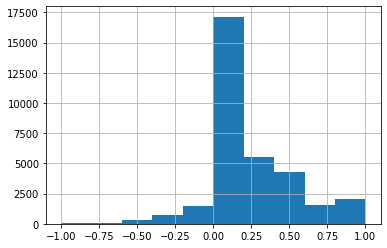

In [14]:
ceo_tweets['sentiment_score'].hist()

#### Sentiments for each CEO

In [15]:
# CEO level sentiment EDA:
ceo_tweets.groupby('username')['sentiment_score'].agg(['min','max','mean','median'])

,min,max,mean,median
username,,,,
@Benioff,-1.000000,1.0,0.178951,0.100000
@BillGates,-1.000000,1.0,0.221416,0.200000
@Bill_Gross,-1.000000,1.0,0.190096,0.150000
@BoeingCEO,-0.500000,1.0,0.288584,0.250000
@ChuckRobbins,-1.000000,1.0,0.384362,0.400000
@IndraNooyi,-0.800000,1.0,0.270405,0.250000
@JeffBezos,-0.250000,1.0,0.253642,0.201389
@JohnLegere,-1.000000,1.0,0.190867,0.000000
@LisaSu,0.000000,1.0,0.442633,0.430000


In [16]:
df_sent_bucket=pd.DataFrame(ceo_tweets.groupby(['username','sentiment_bucket'])['sentiment_score'].agg('count'))

df_sent_bucket=df_sent_bucket.reset_index()
df_sent_bucket.columns=['username','sentiment_bucket','tweet_cnt']
df_sent_bucket[:5]

,username,sentiment_bucket,tweet_cnt
0,@Benioff,negative,254
1,@Benioff,neutral,1255
2,@Benioff,positive,1721
3,@BillGates,negative,96
4,@BillGates,neutral,255


In [17]:
#pivot the results
df_sent_pivot= pd.pivot_table(df_sent_bucket,index=["username"],columns=["sentiment_bucket"])
df_sent_pivot['perc_negative']=df_sent_pivot['tweet_cnt']['negative']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot['perc_positive']=df_sent_pivot['tweet_cnt']['positive']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot['perc_neutral']=df_sent_pivot['tweet_cnt']['neutral']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])

df_sent_pivot

tweet_cnt                  perc_negative perc_positive  \
sentiment_bucket  negative neutral positive                               
username                                                                  
@Benioff             254.0  1255.0   1721.0      7.863777     53.281734   
@BillGates            96.0   255.0    632.0      9.766022     64.292981   
@Bill_Gross          143.0   454.0    866.0      9.774436     59.193438   
@BoeingCEO            10.0   101.0    339.0      2.222222     75.333333   
@ChuckRobbins         38.0   215.0    743.0      3.815261     74.598394   
@IndraNooyi            7.0    41.0     99.0      4.761905     67.346939   
@JeffBezos             6.0    50.0     94.0      4.000000     62.666667   
@JohnLegere          146.0  1831.0   1259.0      4.511743     38.906057   
@LisaSu                NaN     9.0    163.0           NaN           NaN   
@MichaelDell          18.0   315.0    687.0      1.764706     67.352941   
@WaltBettinger        30.0   104.0    315.0      6.681514     70.155902   
@anandmahindra       242.0  1331.0   1648.0      7.513195     51.164235   
@aneelb                5.0    28.0     67.0      5.000000     67.000000   
@bchesky              58.0   254.0    338.0      8.923077     52.000000   
@drewhouston           3.0    30.0     42.0      4.000000     56.000000   
@eldsjal              41.0   193.0    252.0      8.436214     51.851852   
@elonmusk            299.0  1624.0   1324.0      9.208500     40.776101   
@jack                179.0  1856.0   1190.0      5.550388     36.899225   
@levie                65.0   207.0    266.0     12.081784     49.442379   
@lloydblankfein       11.0    21.0     36.0     16.176471     52.941176   
@marissamayer          5.0    37.0     36.0      6.410256     46.153846   
@mtbarra               7.0    72.0    133.0      3.301887     62.735849   
@richardbranson      225.0   866.0   2130.0      6.985408     66.128532   
@rupertmurdoch         NaN     1.0      NaN           NaN           NaN   
@satyanadella         30.0   170.0    301.0      5.988024     60.079840   
@sundarpichai         27.0   113.0    292.0      6.250000     67.592593   
@tim_cook             29.0   162.0    419.0      4.754098     68.688525   
@toddmckinnon         12.0    77.0     92.0      6.629834     50.828729   
@tonyfernandes       277.0  1171.0   1748.0      8.667084     54.693367   
@westernunionCEO      40.0   412.0    464.0      4.366812     50.655022   

                 perc_neutral  
sentiment_bucket               
username                       
@Benioff            38.854489  
@BillGates          25.940997  
@Bill_Gross         31.032126  
@BoeingCEO          22.444444  
@ChuckRobbins       21.586345  
@IndraNooyi         27.891156  
@JeffBezos          33.333333  
@JohnLegere         56.582200  
@LisaSu                   NaN  
@MichaelDell        30.882353  
@WaltBettinger      23.162584  
@anandmahindra      41.322571  
@aneelb             28.000000  
@bchesky            39.076923  
@drewhouston        40.000000  
@eldsjal            39.711934  
@elonmusk           50.015399  
@jack               57.550388  
@levie              38.475836  
@lloydblankfein     30.882353  
@marissamayer       47.435897  
@mtbarra            33.962264  
@richardbranson     26.886060  
@rupertmurdoch            NaN  
@satyanadella       33.932136  
@sundarpichai       26.157407  
@tim_cook           26.557377  
@toddmckinnon       42.541436  
@tonyfernandes      36.639549  
@westernunionCEO    44.978166

In [23]:
df_sent_pivot_plt = df_sent_pivot[[("tweet_cnt","negative"),("tweet_cnt","positive")]]

In [24]:
df_sent_pivot_plt

tweet_cnt         
sentiment_bucket  negative positive
username                           
@Benioff             254.0   1721.0
@BillGates            96.0    632.0
@Bill_Gross          143.0    866.0
@BoeingCEO            10.0    339.0
@ChuckRobbins         38.0    743.0
@IndraNooyi            7.0     99.0
@JeffBezos             6.0     94.0
@JohnLegere          146.0   1259.0
@LisaSu                NaN    163.0
@MichaelDell          18.0    687.0
@WaltBettinger        30.0    315.0
@anandmahindra       242.0   1648.0
@aneelb                5.0     67.0
@bchesky              58.0    338.0
@drewhouston           3.0     42.0
@eldsjal              41.0    252.0
@elonmusk            299.0   1324.0
@jack                179.0   1190.0
@levie                65.0    266.0
@lloydblankfein       11.0     36.0
@marissamayer          5.0     36.0
@mtbarra               7.0    133.0
@richardbranson      225.0   2130.0
@rupertmurdoch         NaN      NaN
@satyanadella         30.0    301.0
@sundarpichai         27.0    292.0
@tim_cook             29.0    419.0
@toddmckinnon         12.0     92.0
@tonyfernandes       277.0   1748.0
@westernunionCEO      40.0    464.0

Text(0.5, 1, 'Fraction of Sentiment Polarity by CEO')

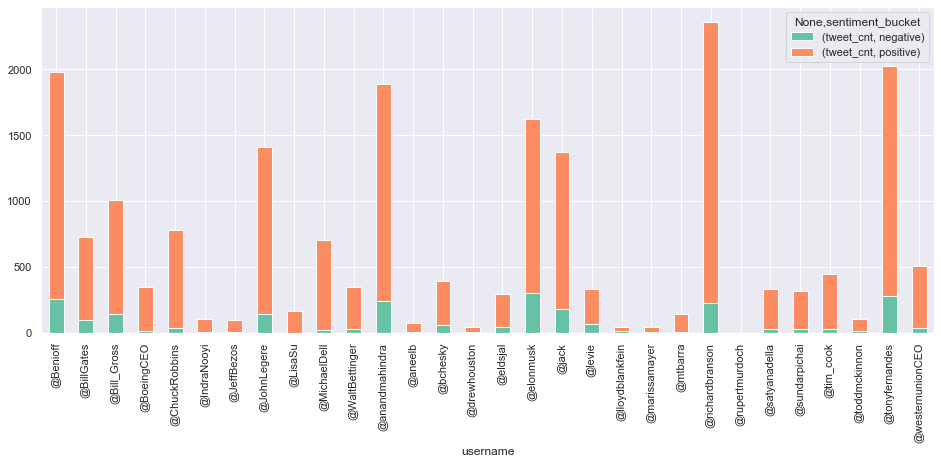

In [31]:
import seaborn as sns
from pylab import rcParams
sns.set(palette="Set2")
df_sent_pivot_plt.plot(kind='bar', stacked = True)
plt.set_title("Fraction of Sentiment Polarity by CEO")

#### Bag of words analysis

In [33]:
## Removing stop words, punctuation and tokenizing

nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')

ceo_tweets["clean_tweets"] = ceo_tweets["clean_tweets"].astype(str)
ceo_tweets["tweet_tokens"] = ceo_tweets["clean_tweets"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
ceo_tweets["tweet_tokens"] = ceo_tweets["tweet_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])

ceo_tweets[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sahana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sahana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,tweet_tokens
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive,"[thanksgiving, reflecting, dreamers, enjoy, da..."
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive,"[wishing, everyone, happythanksgiving, filled,..."
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...,0.900000,positive,"[tomorrow, incredible, mnightshyamalan, series..."
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...,0.000000,neutral,"[thanksgiving, day, challenge, close, rings, f..."
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive,"[many, travel, loved, ones, today, remember, p..."
